# Lab 05 - Bayesian Optimization
## Tasks
- Construct a 1D Bayesian model of the xrms beam size after a single quadrupole as a function of its strength parameter
- Write your own upper confidence bound acquisition function
- Minimize $\sigma_x$
- Construct a 3D Bayesian model of the xrms beam size after a quadrupole triplet and minimize $\sqrt{\sigma_x^2 + \sigma_y^2}$

# Set up environment

In [1]:
!pip install git+https://github.com/uspas/2021_optimization_and_ml --quiet

In [2]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#import toy accelerator package
from uspas_ml.accelerator_toy_models import simple_lattices
from uspas_ml.utils import transformer

#import packages required for BO
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

## Creating a 1D single objective function
- input is the geometric quad strength and the initial beam matrix
- output is the final rms beam size

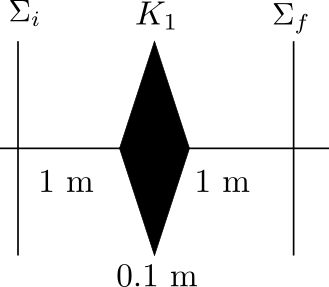

In [3]:
def xrms_1D(K1, noise = 0.0):
    '''
    calculate sigma_x^2
    
    K1 : magnetic strength of single quad magnet, torch.tensor, shape (1,)
    noise : rms noise level of measurement, float (default 0.0)
    
    '''
    
    #generate initial beam matrix
    # - x/y/z geometric emittance of 1.0e-8 m-rad
    init_beam_matrix = torch.eye(6) * 1.0e-8

    #set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
    init_beam_matrix[0,0] = 1.0e-3 ** 2 
    init_beam_matrix[1,1] = 1.0e-4 ** 2 
    init_beam_matrix[2,2] = 1.0e-3 ** 2 
    init_beam_matrix[3,3] = 1.0e-4 ** 2  
    
    #create accelerator lattice object with one quad and a drift
    line = simple_lattices.create_singlet(K1)
    
    #propagate beam matrix
    final_beam_matrix = line.propagate_beam_matrix(init_beam_matrix, noise)
    return final_beam_matrix[0,0].reshape(1,1).detach()

## Creating a 1D GP model
- set up design space bounds. (-300, 300) for each quad works well for this beamline
- create several training sample pairs (x,y) to initalize the model with
- create GP model and likelihood

In [4]:
#specify bounds (also used for optimization)
bounds = torch.tensor([-300.0, 300.0])
diff = bounds[1] - bounds[0]

#define transformer for x values
transformer_x = transformer.Transformer(bounds.reshape(2,1),
                                        transform_type = 'normalize')
print(transformer_x.mins)
print(transformer_x.maxs)

#generate input space training samples
n_samples = 5
train_x = torch.rand(n_samples) * diff + bounds[0]
train_x = train_x.reshape(-1,1)

#do observations of the objective
train_y = torch.cat([xrms_1D(torch.tensor(K)) for K in train_x]).detach()


#normalize x
normed_train_x = transformer_x.forward(train_x)

#create standardize_y transformer -> transforms input such that data has a mean of 0.0 and a std of 1.0
transformer_y = transformer.Transformer(train_y, 
                                        transform_type = 'standardize')

normed_train_y = transformer_y.forward(train_y)

print(normed_train_x)
print(normed_train_y)

#add training data to model and fit

#Gaussian Process model with Matern(5/2) kernel and Gaussian likelihood
gp = SingleTaskGP(normed_train_x, normed_train_y)

# train model hyperparameters minimizing negative-Log-Marginal-Likelihood
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);


[-300.]
[300.]
tensor([[0.3185],
        [0.5664],
        [0.4166],
        [0.1759],
        [0.3771]])
tensor([[ 0.2253],
        [-1.2084],
        [-0.5319],
        [ 1.7720],
        [-0.2570]])


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Plot samples from the 1D model

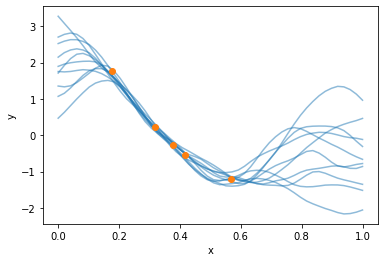

In [5]:
#use the normalized range
x = torch.linspace(0, 1, 50)
#specify number of samples
n_samples = 10
with torch.no_grad():
    p = gp.posterior(x)
    s = p.rsample(torch.Size([n_samples]))

fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')

#plot samples from posterior model
for sample in s:
    ax.plot(x, sample,'C0',alpha = 0.5)

#plot measurements
ax.plot(normed_train_x, normed_train_y,'oC1')

## Plot the 1D model probability distribution

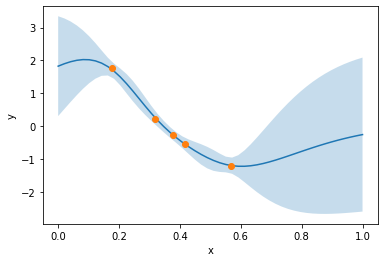

In [6]:
#plot the gp distribution in the normalized range
x = torch.linspace(0, 1, 50)
with torch.no_grad():
    p = gp.posterior(x)
    
    #get the mean
    m = p.mean
    
    #get the 2 sigma confidence region around the mean
    l,u = p.mvn.confidence_region() 

fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
#plot mean and confidence region
ax.plot(x, m)
ax.fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

#plot samples
ax.plot(normed_train_x, normed_train_y,'oC1')

## Examine acquisition functions for optimization
- Here we will plot two different acquisition functions that we are using to minimize the function in our domain
- Probability of improvement (PI)
- Expected improvement (EI)
- NOTE: BoTorch always assumes maximization by default (don't ask me why)

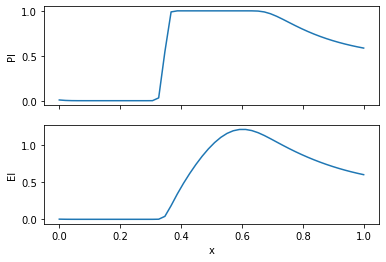

In [7]:
from botorch.acquisition.analytic import ProbabilityOfImprovement, ExpectedImprovement

best_y = torch.min(train_y)

#Probability of Improvement
PI = ProbabilityOfImprovement(gp, best_y, maximize = False)

#Expected Improvement
EI = ExpectedImprovement(gp, best_y, maximize = False)

#need to reshape x to fit in argument
test_x = x.reshape(-1,1,1)

fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].set_ylabel('PI')
ax[1].set_ylabel('EI')
ax[1].set_xlabel('x')

ax[0].plot(x,PI(test_x).detach())
ax[1].plot(x,EI(test_x).detach())

## Exercise: Write function to calculate Upper Confidence Bound
<div class="alert alert-block alert-info">
    
**Task:**
    Create an implementation of the UCB acquisition function. You can access the posterior mean via `posterior.mean` and the variance via `posterior.variance`.
    
**Task:**
    Plot the UCB acquisition function from x = \[0,1\] for three different values of $\beta$ = \[0.01, 2.0, 10.0\] 
    
</div>

In [8]:
def UCB(X, model, beta):
    pass

## Do optimization
- Here we take several optimization steps using EI
- Retrain the model hyperaparameters at each step (cheap if the number of points is small)

<div class="alert alert-block alert-info">
    
**Task:**
    Write optimization loop to optimize this function. See optimize_acqf documentation for details. https://botorch.org/v/0.3.0/ Retrain a new GP model at each step.
    
</div>

In [1]:
from botorch.optim import optimize_acqf

#re-generate initialization data
#-------------------------------------------------------

#generate input space training samples
n_samples = 3
train_x = torch.rand(n_samples) * diff + bounds[0]
train_x = train_x.reshape(-1,1)

#do observations of the objective
train_y = torch.cat([xrms_1D(torch.tensor(K)) for K in train_x]).detach()

#normalize x
normed_train_x = transformer_x.forward(train_x)

#create standardize_y transformer -> transforms input such that data has a mean of 0.0 and a std of 1.0
transformer_y = transformer.Transformer(train_y, 
                                        transform_type = 'standardize')

normed_train_y = transformer_y.forward(train_y)

#start optimization
#-------------------------------------------------

n_steps = 4

for i in range(n_steps):
    
    #Expected Improvement
    best_normed_y = torch.min(normed_train_y)
    print(torch.min(train_y))
    EI = ExpectedImprovement(gp, best_normed_y, maximize = False)
    
    
    ######################################
    # INSERT YOUR CODE HERE
    ######################################
    
    
    ######################################
       
    #plot points and gp posterior
    x = torch.linspace(0, 1, 50)
    with torch.no_grad():
        p = gp.posterior(x)
    
        #get the mean
        m = p.mean
    
        #get the 2 sigma confidence region around the mean
        l, u = p.mvn.confidence_region() 

    fig,ax = plt.subplots()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #plot mean and confidence region
    ax.plot(x, m)
    ax.fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

    #plot samples
    ax.plot(normed_train_x, normed_train_y,'oC1')


NameError: name 'torch' is not defined

## Accelerator example
Now we will use BO to optimize the strengths of quadrupoles in a triplet configuration. 

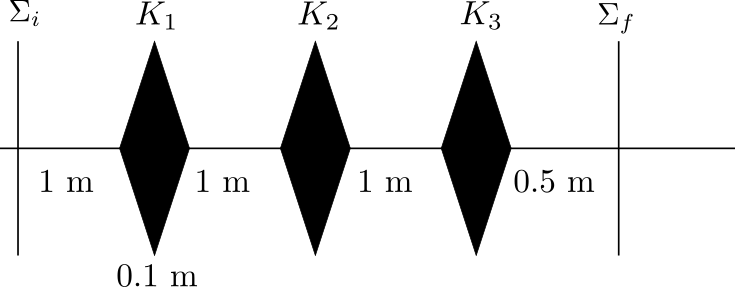

The function below creates a quadrupole triplet as defined in simple_lattices.py (see the accelerator toy models) and returns $\sqrt{\sigma_x^2 + \sigma_y^2}$ for an initial beam matrix defined in the function below.

Remember that the beam matrix takes the form of 

$
\Sigma = 
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \sigma_{13} & \sigma_{14} & \sigma_{15} & \sigma_{16} \\
\sigma_{21} & \sigma_{22} & \sigma_{23} & \sigma_{24} & \sigma_{25} & \sigma_{26} \\
\sigma_{31} & \sigma_{32} & \sigma_{33} & \sigma_{34} & \sigma_{35} & \sigma_{36} \\
\sigma_{41} & \sigma_{42} & \sigma_{43} & \sigma_{44} & \sigma_{45} & \sigma_{46} \\
\sigma_{51} & \sigma_{52} & \sigma_{53} & \sigma_{54} & \sigma_{55} & \sigma_{56} \\
\sigma_{61} & \sigma_{62} & \sigma_{63} & \sigma_{64} & \sigma_{65} & \sigma_{66} \\
\end{bmatrix}
$

where for example $\sigma_{11} = \sigma_x^2, \sigma_{12} = \sigma_{x,x'}$ etc.

We start with an initial beam matrix that has a 2D geometric emittance of 1.0e-8 m.rad and a transverse spot size of 10 x 10 mm.

$
\Sigma = 
\begin{bmatrix}
1e-4 & 0 & 0 & 0 & 0 & 0 \\
0 & 1e-12 & 0 & 0 & 0 & 0 \\
0 & 0 & 1e-4 & 0 & 0 & 0 \\
0 & 0 & 0 & 1e-12 & 0 & 0 \\
0 & 0 & 0 & 0 & 1e-8 & 0 \\
0 & 0 & 0 & 0 & 0 & 1e-8 \\
\end{bmatrix}
$

In [10]:
def beamsize(K , noise = 0.1):
    '''
    calculate sqrt(sigma_x^2 + sigma_y^2) from the beamline above (positions of each quad is fixed)
    
    K : magnetic strength of each quad magnet, torch.tensor, shape (3,)
    noise : rms noise level of measurement, float (default 0.0)
    
    '''
    
    #generate initial beam matrix
    # - z geometric emittance of 1.0e-8 m-rad
    init_beam_matrix = torch.eye(6) * 1.0e-8

    #set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
    init_beam_matrix[0,0] = 1.0e-3 ** 2 
    init_beam_matrix[1,1] = 1.0e-4 ** 2 
    init_beam_matrix[2,2] = 1.0e-3 ** 2 
    init_beam_matrix[3,3] = 1.0e-4 ** 2 
    
    #create accelerator lattice object with one quad and a drift
    line = simple_lattices.create_triplet(K)
    
    #propagate beam matrix
    final_beam_matrix = line.propagate_beam_matrix(init_beam_matrix, noise)
    return torch.sqrt(final_beam_matrix[0,0] + final_beam_matrix[2,2])

## Exercise: Optimize the quadrupole triplet with noise using BO
<div class="alert alert-block alert-success">
    
**Homework:**
    Minimize the beamsize function above, subject to noise, using Baysesian optimization and the three quadrupole parameters (K1, K2, K3). Use the same bounds as before (-300, 300) for each quadrupole.

</div>